In [54]:
library('cluster')

ERROR: Error in library("cluster"): there is no package called ‘cluster’


In [1]:
archivosdf <- list.files(path = '../3.Datos generados/dataframes', pattern = "^df_grid_", full.names = TRUE)
archivosdf

[1] "../3.Datos generados/dataframes/df_grid_05.Rdata"
[2] "../3.Datos generados/dataframes/df_grid_1.Rdata" 
[3] "../3.Datos generados/dataframes/df_grid_15.Rdata"
[4] "../3.Datos generados/dataframes/df_grid_2.Rdata" 
[5] "../3.Datos generados/dataframes/df_grid_25.Rdata"
[6] "../3.Datos generados/dataframes/df_grid_3.Rdata" 
[7] "../3.Datos generados/dataframes/df_grid_4.Rdata" 
[8] "../3.Datos generados/dataframes/df_grid_5.Rdata"

In [112]:
ruta = '../3.Datos generados/dataframes/df_grid_1.Rdata'
ruta_grid = '../1.Upscaling/upscaling_ba/ba_grid_1.Rdata'

In [113]:
df_grid <- get(load(ruta))
df_grid$orden <- seq(1,nrow(df_grid))

In [114]:
df_grid_filtered <- df_grid[df_grid$FsOrNot != 0 & is.na(df_grid$SencondStart),  ]
df_grid_filt_norm <- scale(df_grid_filtered[,8:10])

Warning message:
“did not converge in 10 iterations”


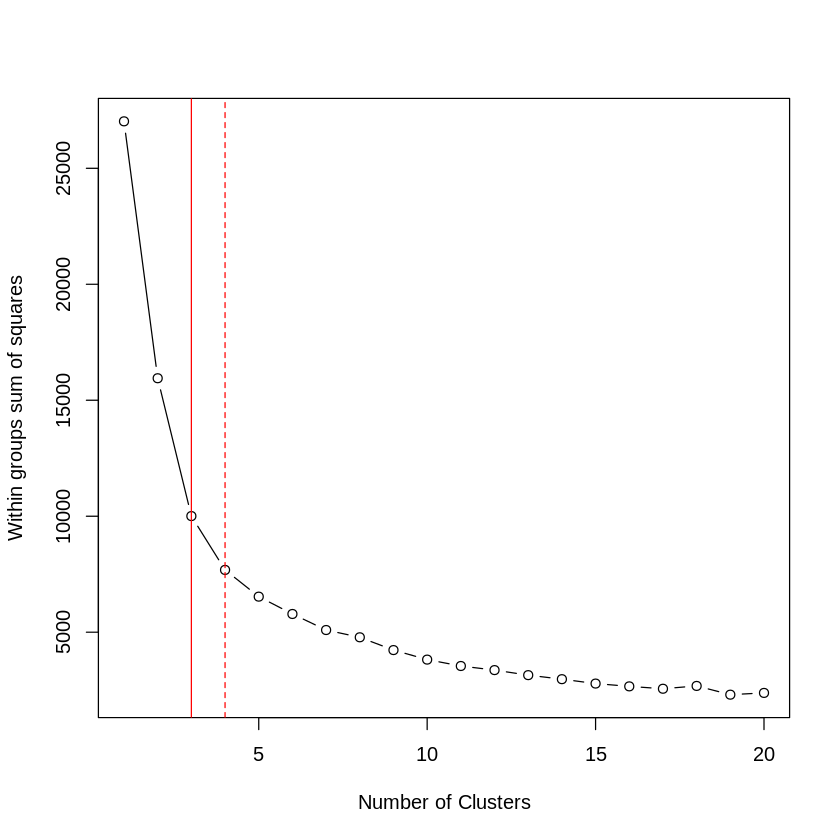

In [129]:
wss <- (nrow(df_grid_filt_norm)-1)*sum(apply(df_grid_filt_norm,2,var))
for (i in 2:20) wss[i] <- sum(kmeans(df_grid_filt_norm, centers=i)$withinss)
plot(1:20, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
abline(v = 3, col = 'red')
abline(v = 4, lty = 2:3, col = 'red1')


3 es el valor óptimo de clusteres. Además incluiremos un cuarto para las bimodales

Visualizamos un árbol

In [116]:
distance = dist(df_grid_filt_norm)
grid.hclust = hclust(distance)
plot(grid.hclust)

In [117]:
member = cutree(grid.hclust,3)
table(member)

member
   1    2    3 
6810 1232  967 

Clusterizamos con k-means

In [118]:
kc <- kmeans(df_grid_filt_norm,3)
member2 <- kc$cluster
table(member2)

member2
   1    2    3 
4132 2773 2104 

In [119]:
df_grid_cl1 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==1]), ]
df_grid_cl2 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==2]), ]
df_grid_cl3 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==3]), ]
#df_grid_cl4 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==4]), ]


df_grid_cl1$cluster <- 1
df_grid_cl2$cluster <- 2
df_grid_cl3$cluster <- 3
#df_grid_cl4$cluster <- 4



#A las bimodales les asignamos un cluster propio
df_grid_bimodales <- df_grid[df_grid$FsOrNot != 0 & !is.na(df_grid$SencondStart),  ]
df_grid_bimodales$cluster <- 4
#Las que no tienen fire seasson las dejamos como NA
df_grid_sinFireSesasson <- df_grid[df_grid$FsOrNot == 0,  ]
df_grid_sinFireSesasson$cluster <- 0

nuevo_df_grid <- rbind(df_grid_cl1,df_grid_cl2, df_grid_cl3,df_grid_bimodales,df_grid_sinFireSesasson)
nuevo_df_grid<- nuevo_df_grid[order(nuevo_df_grid$orden),]
nuevo_df_grid$orden <- NULL

Visualizamos

In [120]:
library("visualizeR")

quantity2clim <- function(quantity, what, ref.grid, backperm = NULL) {
  if(!is.null(backperm)){quantity <- quantity[backperm]}
  mat <- matrix(quantity, nrow = 1)  
  ref.grid$Data <- mat2Dto3Darray(mat, x = ref.grid$xyCoords$x , y = ref.grid$xyCoords$y)
  attr(ref.grid$Data, "climatology:fun") <- what
  return(ref.grid)
}


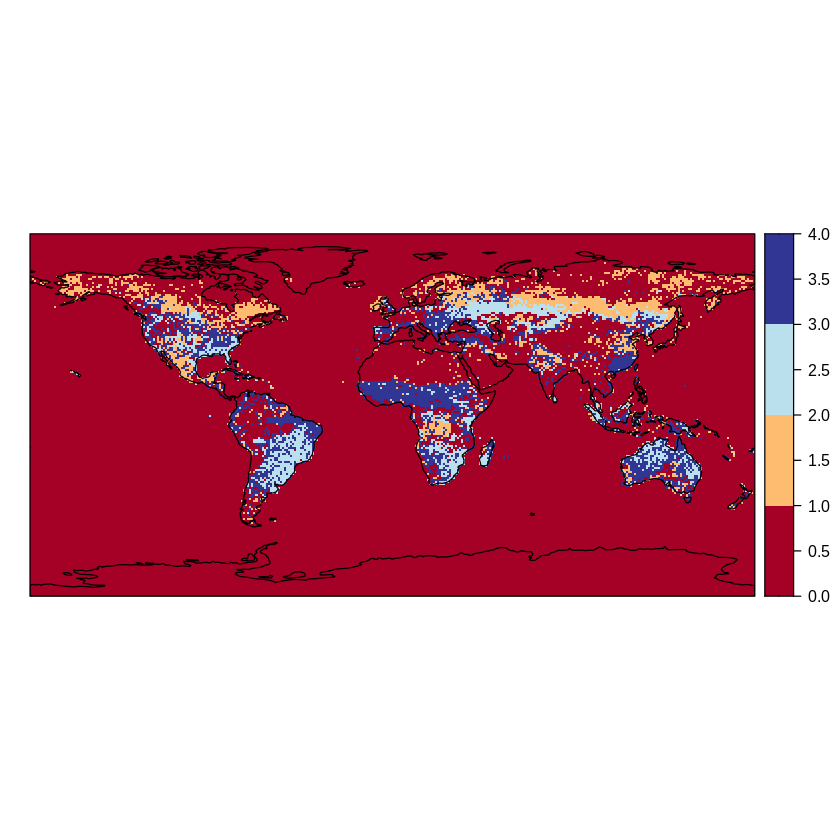

In [121]:
ref.grid = get(load(ruta_grid))
clim <- quantity2clim(quantity = nuevo_df_grid$cluster,what = 'Clusters',ref.grid = ref.grid )
plotClim <- spatialPlot(clim,backdrop.theme = 'coastline',at = seq(0,4))
plotClim

In [85]:
plotname <- "clusters05.pdf"
pdf(plotname)
plotClim
dev.off()

png 
  2

In [122]:
clusters <- c(1:4)
num_pixeles <- c()
media_mainFireStart <- c()
desv_mainFireStart <- c()
media_mainFireEnd <- c()
desv_mainFireEnd <- c()
num_bimodal <- c()
media_fireSeassonLength <- c()
desv_fireSeassonLength <- c()
media_SeassonalConcentration <- c()
desv_SeassonalConcentration <- c()
media_SeassonalTiming <- c()
desv_SeassonalTiming <- c()
for (cluster in clusters){
    df_cluster <- nuevo_df_grid[nuevo_df_grid$cluster == cluster, ]
    df_bimodales <- df_cluster[!is.na(df_cluster$SencondStart), ] 
    
    num_pixeles <- c(num_pixeles, nrow(df_cluster))
    media_mainFireStart <- c(media_mainFireStart, mean(df_cluster$MainStart))
    desv_mainFireStart <- c(desv_mainFireStart, sd(df_cluster$MainStart))
    media_mainFireEnd <- c(media_mainFireEnd, mean(df_cluster$MainEnd))
    desv_mainFireEnd <- c(desv_mainFireEnd, sd(df_cluster$MainEnd))
    media_fireSeassonLength <- c(media_fireSeassonLength, mean(df_cluster$Length))
    desv_fireSeassonLength <- c(desv_fireSeassonLength, sd(df_cluster$Length))
    media_SeassonalConcentration <- c(media_SeassonalConcentration, mean(df_cluster$C))
    desv_SeassonalConcentration <- c(desv_SeassonalConcentration, sd(df_cluster$C))
    media_SeassonalTiming <- c(media_SeassonalTiming, mean(df_cluster$P))
    desv_SeassonalTiming <- c(desv_SeassonalTiming, sd(df_cluster$P))
    num_bimodal <- c(num_bimodal, nrow(df_bimodales))
}
df_comparativaClusters <- data.frame(clusters, num_pixeles, num_bimodal, media_mainFireStart, desv_mainFireStart, 
                                  media_mainFireEnd, desv_mainFireEnd,media_fireSeassonLength, desv_fireSeassonLength,
                                  media_SeassonalConcentration, desv_SeassonalConcentration, media_SeassonalTiming,desv_SeassonalTiming)
df_comparativaClusters

clusters,num_pixeles,num_bimodal,media_mainFireStart,desv_mainFireStart,media_mainFireEnd,desv_mainFireEnd,media_fireSeassonLength,desv_fireSeassonLength,media_SeassonalConcentration,desv_SeassonalConcentration,media_SeassonalTiming,desv_SeassonalTiming
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4132,0,4.397870,2.413244,5.848258,2.489283,2.450387,1.346776,0.9088460,0.07411133,1.03738733,0.3853687
2,2773,0,4.556076,2.194586,5.572665,1.882613,2.016589,1.279097,0.9012486,0.09520796,-0.84735389,0.5415653
3,2104,0,1.806559,1.131041,8.009030,1.603436,7.202471,1.972438,0.5834229,0.20353783,0.27902197,0.8235212
4,3545,3545,1.814669,1.362100,3.483216,1.931038,5.478420,2.134884,0.7041680,0.20523607,0.02341633,0.9294754


In [123]:
Cluster <- c(1,NA,2,NA,3,NA,4,NA)
Píxeles <- c()
Bimodales <- c()
Comienzo <- c()
Final <- c()
Duración <- c()
C <- c()
T <- c()
for (cluster in 1:4){
    df_cluster <- nuevo_df_grid[nuevo_df_grid$cluster == cluster, ]
    df_bimodales <- df_cluster[!is.na(df_cluster$SencondStart), ] 
    
    Píxeles <- c(Píxeles, nrow(df_cluster), NA)
    
    Bimodales <- c(Bimodales, nrow(df_bimodales), NA)
    
    MainStart <- c(Comienzo, mean(df_cluster$MainStart),sd(df_cluster$MainStart))

    MainEnd <- c(Final, mean(df_cluster$MainEnd),sd(df_cluster$MainEnd))
    
    Length <- c(Duración, mean(df_cluster$Length), sd(df_cluster$Length))

    C <- c(C, mean(df_cluster$C), sd(df_cluster$C))

    P <- c(T, mean(df_cluster$P), sd(df_cluster$P))
}
df_comparativaClusters <- data.frame(
  Cluster,
  Píxeles,
  Bimodales,
  MainStart,
  MainEnd,
  Length,
  C,
  P
)
df_comparativaClusters

Cluster,Píxeles,Bimodales,MainStart,MainEnd,Length,C,P
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4132,0,1.814669,3.483216,5.478420,0.90884601,0.02341633
NA,NA,NA,1.362100,1.931038,2.134884,0.07411133,0.92947544
2,2773,0,1.814669,3.483216,5.478420,0.90124864,0.02341633
NA,NA,NA,1.362100,1.931038,2.134884,0.09520796,0.92947544
3,2104,0,1.814669,3.483216,5.478420,0.58342293,0.02341633
NA,NA,NA,1.362100,1.931038,2.134884,0.20353783,0.92947544
4,3545,3545,1.814669,3.483216,5.478420,0.70416804,0.02341633
NA,NA,NA,1.362100,1.931038,2.134884,0.20523607,0.92947544


In [124]:
library(xtable)
table <- xtable(df_comparativaClusters)
print(table, include.rownames = FALSE)

% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Sat Sep 16 16:35:49 2023
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrr}
  \hline
Cluster & Píxeles & Bimodales & MainStart & MainEnd & Length & C & P \\ 
  \hline
1.00 & 4132 &   0 & 1.81 & 3.48 & 5.48 & 0.91 & 0.02 \\ 
   &  &  & 1.36 & 1.93 & 2.13 & 0.07 & 0.93 \\ 
  2.00 & 2773 &   0 & 1.81 & 3.48 & 5.48 & 0.90 & 0.02 \\ 
   &  &  & 1.36 & 1.93 & 2.13 & 0.10 & 0.93 \\ 
  3.00 & 2104 &   0 & 1.81 & 3.48 & 5.48 & 0.58 & 0.02 \\ 
   &  &  & 1.36 & 1.93 & 2.13 & 0.20 & 0.93 \\ 
  4.00 & 3545 & 3545 & 1.81 & 3.48 & 5.48 & 0.70 & 0.02 \\ 
   &  &  & 1.36 & 1.93 & 2.13 & 0.21 & 0.93 \\ 
   \hline
\end{tabular}
\end{table}
